# Malaysia

## Calculate and visualize average enterprise age across Malaysia
The data below is from the World Bank's Enterprise Survey - (2015-2016). It's [available](https://enterprisesurveys.org/portal/index.aspx) on the WB ES webiste.

With any survey data, sample weights are important to generalize from the sample to the population.

- **Objective: Calculate and visualize average firm age across Malaysia's regions**

In [195]:
import pandas as pd
import numpy as np
import geopandas as gpd
import requests
from shapely.geometry import Point
import pylab as plt
%pylab inline
import seaborn as sns
import mplleaflet as mpll
import osmnx as ox
from IPython.display import Image
import matplotlib.pyplot as plt2

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


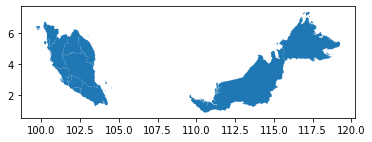

In [141]:
malaysia_GADM = gpd.read_file('data/malaysia/gadm36_MYS_1.shp')
malaysia_GADM.plot()

In [142]:
# List MYS regions on GADM
malaysia_GADM['NAME_1'].value_counts()

Kedah              1
Selangor           1
Perak              1
Negeri Sembilan    1
Sarawak            1
Trengganu          1
Melaka             1
Johor              1
Labuan             1
Pulau Pinang       1
Kuala Lumpur       1
Putrajaya          1
Perlis             1
Kelantan           1
Pahang             1
Sabah              1
Name: NAME_1, dtype: int64

In [143]:
East_Malaysia = ['Sarawak','Labuan','Sabah']
North = ['Kedah', 'Perak', 'Pulau Pinang', 'Perlis']
East_Coast = ['Trengganu', 'Kelantan', 'Pahang']
South = ['Johor']
Central = ['Selangor', 'Negeri Sembilan', 'Kuala Lumpur', 'Putrajaya', 'Melaka']

def remap_mystates(region):
    if region in East_Malaysia:
        return('East Malaysia')
    elif region in North:
        return('North')
    elif region in East_Coast:
        return('East Coast')
    elif region in South:
        return('South')
    elif region in Central:
        return('Central')
    else:
        return('error!')

In [144]:
df_my = pd.read_csv('data/malaysia/MYS_ES_2016.csv')
df_my.head()

,region,size,own_domestic,own_foreign,own_gov,own_other,year_estab,weight,ageofbiz
0,East Malaysia,Small,40,0,0,60,2014,97.214439,1
1,North,Medium,70,30,0,0,2014,66.450867,2
2,East Coast,Medium,100,0,0,0,2013,184.729750,2
3,East Coast,Medium,100,0,0,0,2013,5.526067,2
4,East Coast,Medium,100,0,0,0,2013,5.526067,2


In [145]:
df_my.rename(columns = {'own_domestic':'share_dom','own_foreign':'share_foreign','own_gov':'share_govt'}, inplace=True)

In [146]:
df_my.head()

,region,size,share_dom,share_foreign,share_govt,own_other,year_estab,weight,ageofbiz
0,East Malaysia,Small,40,0,0,60,2014,97.214439,1
1,North,Medium,70,30,0,0,2014,66.450867,2
2,East Coast,Medium,100,0,0,0,2013,184.729750,2
3,East Coast,Medium,100,0,0,0,2013,5.526067,2
4,East Coast,Medium,100,0,0,0,2013,5.526067,2


#### 1. Inspect data and remove outliers

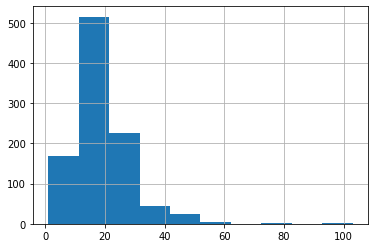

In [147]:
# view the distribution of the age of firms
df_my.ageofbiz.hist() 

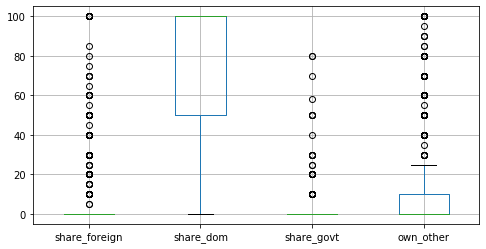

In [148]:
# view box plots of ownership shares by type
df_my[['share_foreign', 'share_dom', 'share_govt', 'own_other']].boxplot(figsize = [8,4])

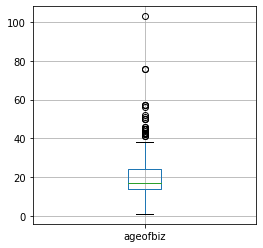

In [149]:
# view box plots of age
df_my[['ageofbiz']].boxplot(figsize = [4,4])

In [150]:
print("Oldest establishment in sample: ", df_my.ageofbiz.max())
print("The average (mean) age is: ", df_my.ageofbiz.mean())
print("The average (median) age is: ", df_my.ageofbiz.median())

Oldest establishment in sample:  103
The average (mean) age is:  19.196138211382113
The average (median) age is:  17.0


In [151]:
# Remove observations more than 3 standard deviations above the mean age
df_my['ageofbiz'][df_my['ageofbiz'] > (df_my.ageofbiz.mean()
                                                     + df_my.ageofbiz.std() * 3)] = np.nan
df_my.dropna(inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


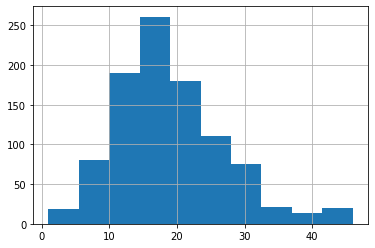

In [153]:
# view the distribution of the age of firms again - the distribution is now more normal
df_my.ageofbiz.hist()

#### 2. Calculate mean age of establishment by region and size.

The Pandas groupby function makes this easy. It does three things:
* Split the data into groups.
* Applie a function to each group independently (eg. sum, mean, counts).
* Combine the results into a data structure.

In [154]:
df_my.groupby(['region'])['ageofbiz'].mean()

region
Central          17.956204
East Coast       19.046980
East Malaysia    20.170213
North            19.913462
South            17.050000
Name: ageofbiz, dtype: float64

In [155]:
df_my.groupby(['size'])['ageofbiz'].mean()

size
Large     21.228873
Medium    18.306709
Small     17.053333
Name: ageofbiz, dtype: float64

#### Use sample weights to get representative estimates

In [156]:
def weighted_mean(values, weights):
    return sum(values * weights) / weights.sum()

In [157]:
weighted_mean(values = df_my.ageofbiz[df_my.region == 'Central'],
             weights = df_my.weight[df_my.region == 'Central'])

15.388496842942706

In [158]:
weighted_means_table = pd.Series({region: weighted_mean(df_my.ageofbiz[df_my.region == region],
                                  df_my.weight[df_my.region == region]) for region in df_my.region.unique()},
                                name = 'mean_ageofbiz')

In [159]:
weighted_means_table.head()

East Malaysia    17.978777
North            20.542607
East Coast       13.634069
South            13.059007
Central          15.388497
Name: mean_ageofbiz, dtype: float64

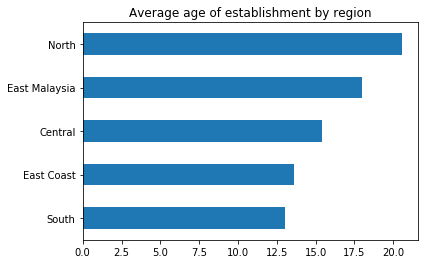

In [160]:
weighted_means_table.sort_values(ascending = True).plot(kind='barh')
plt.title('Average age of establishment by region');

In [161]:
malaysia_GADM['region'] = malaysia_GADM.NAME_1.apply(remap_mystates)

In [162]:
# Create a new geodataframe comprising merged polygons

regions = malaysia_GADM.dissolve(by = 'region')

In [163]:
regions.head(20)

,geometry,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1
region,,,,,,,,,,,
Central,"(POLYGON ((102.33499908 2.04833293, 102.335281...",MYS,Malaysia,MYS.4_1,Kuala Lumpur,Federal Territory of Kuala Lumpur,None,Wilayah Persekutuan,Federal Territory,None,MY.KL
East Coast,"(POLYGON ((103.45878601 3.4653151, 103.4582290...",MYS,Malaysia,MYS.3_1,Kelantan,<Null>,None,Negeri,State,None,MY.KN
East Malaysia,"(POLYGON ((118.62939453 4.11226416, 118.629058...",MYS,Malaysia,MYS.5_1,Labuan,Federal Territory of Labuan,None,Wilayah Persekutuan,Federal Territory,None,MY.LA
North,"(POLYGON ((100.10290527 3.97631788, 100.102996...",MYS,Malaysia,MYS.2_1,Kedah,Kedah Darul Aman,None,Negeri,State,None,MY.KH
South,"(POLYGON ((104.11413574 2.17112207, 104.113540...",MYS,Malaysia,MYS.1_1,Johor,Johor Darul Takzim|Johore,None,Negeri,State,None,MY.JH


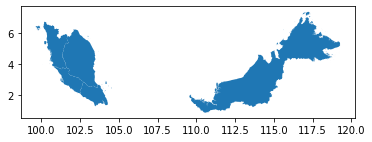

In [164]:
regions.plot()

In [165]:
regions.shape

(5, 11)

In [166]:
weighted_means_table.shape

(5,)

In [167]:
regions_merged = pd.merge(regions, weighted_means_table, left_index=True, right_index=True)

In [168]:
regions_merged = gpd.GeoDataFrame(regions_merged)

In [187]:
description=print("Source: Own analysis of data from the World Bank's Enterprise Survey, 2016")

Source: Own analysis of data from the World Bank's Enterprise Survey, 2016


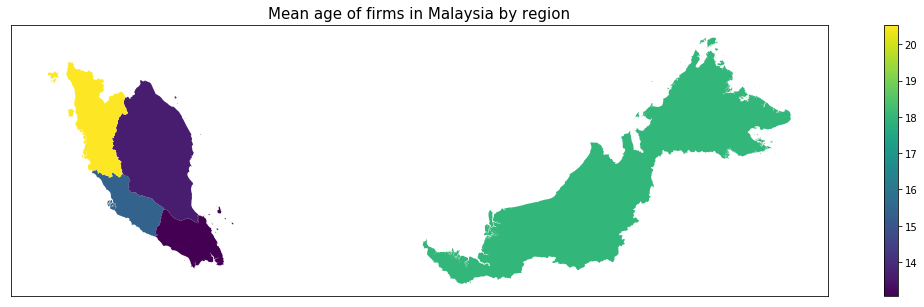

In [231]:
regions_merged.plot(column = 'mean_ageofbiz', legend = True, figsize = [20,5])
plt.title('Mean age of firms in Malaysia by region', fontdict={'fontsize': 15});
plt.xticks([])
plt.yticks([])
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  """


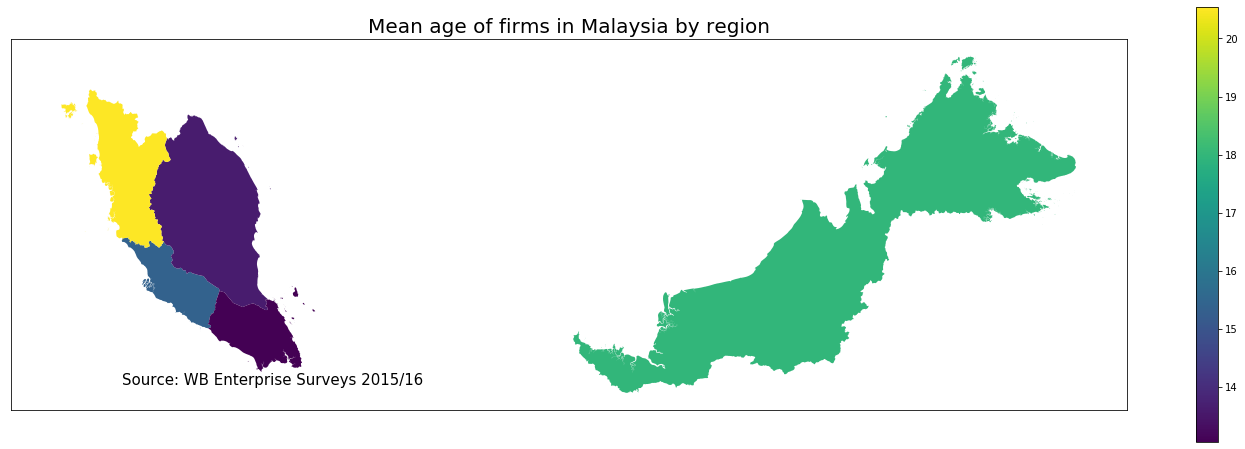

In [218]:
regions_merged.plot(column = 'mean_ageofbiz', legend = True, figsize = [25,8])
plt2.title('Mean age of firms in Malaysia by region', fontdict={'fontsize': 20});
plt2.xticks([])
plt2.yticks([])
plt2.annotate('Source: WB Enterprise Surveys 2015/16', xy=(0.1, 0.1), size=15, xycoords='axes fraction', textcoords='offset points', va='top')
plt2.gca().axes.get_yaxis().set_visible(False)
plt2.show()